<!-- # 005 RL/DQL In Trading

- Antonio Lomelí Ureña
- Carolina Martínez Escalante
- Enrique Tonatiuh Pérez Cortés Barba

#### In this project, we explore the application of Reinforcement Learning (RL) / Deep Q-Learning (DQL)—to the domain of algorithmic trading and portfolio management. Reinforcement Learning offers a powerful framework for training agents that learn to make sequential decisions through interaction with a dynamic environment. Unlike supervised learning, RL does not rely on labeled data but instead optimizes behavior through trial and error, guided by rewards and penalties. -->

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

import itertools
import seaborn as sns
sns.set()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")

np.random.seed(42)
torch.manual_seed(42)

Dispositivo: cpu


In [2]:
# Funcions for technical indicators
def rsi_indicator(prices: pd.Series, rolling:int=14):
    """
    Calculate the Relative Strength Index (RSI) for a given price series.

    Parameters:
    prices (pd.Series): A pandas Series containing the price data.
    rolling (int): The number of periods to use for the RSI calculation.

    Returns:
    pd.Series: A pandas Series containing the RSI values.
    """
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(rolling).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(rolling).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(0)

def macd_indicator(prices: pd.Series, upper: int = 12, lower: int = 26, signal: int = 9):
    """
    Calculate the Moving Average Convergence Divergence (MACD) for a given price series.
    Parameters:
    prices (pd.Series): A pandas Series containing the price data.
    upper (int): The period for the short-term EMA.
    lower (int): The period for the long-term EMA.
    signal (int): The period for the signal line EMA.
    Returns:
    pd.Series: A pandas Series containing the MACD values.
    """

    ema_12 = prices.ewm(span=upper).mean()
    ema_26 = prices.ewm(span=lower).mean()

    macd = ema_12 - ema_26
    signal_ = macd.ewm(span=signal).mean()
    hist = macd - signal_
    return hist.fillna(0)


# 1. Data Collection

In [3]:
# Download closing prices (2020–2025)
data = yf.download('BTC-USD', start='2020-01-01', end='2025-01-01')
data.columns = data.columns.droplevel(1)
prices = data['Close'].values

# Technical feature calculation for trading:
data['Returns'] = data['Close'].pct_change()
data['SMA_20'] = data['Close'].rolling(20).mean()
data['SMA_5'] = data['Close'].rolling(5).mean()
data['Trading_Signal'] = np.where(data['SMA_20'] > data['SMA_5'], 1, 0)
data["RSI"] = rsi_indicator(data['Close'])
data["MACD"] = macd_indicator(data['Close'])

# Remove rows with NaN values
data.dropna(inplace=True)

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[['Close', 'SMA_5', 'SMA_20', "RSI", "MACD", 'Returns']])

data.head()

C:\Users\tony_\AppData\Local\Temp\ipykernel_21516\145357448.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('BTC-USD', start='2020-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Returns,SMA_20,SMA_5,Trading_Signal,RSI,MACD
Date,,,,,,,,,,,
2020-01-20,8657.642578,8745.590820,8560.473633,8704.631836,26422375678,-0.005582,8118.971240,8791.904102,0,67.147141,26.304010
2020-01-21,8745.894531,8755.706055,8544.520508,8658.991211,24097418512,0.010194,8196.257251,8796.325781,0,62.743188,17.092818
2020-01-22,8680.875977,8792.994141,8636.747070,8744.210938,22600204051,-0.007434,8281.027539,8746.693359,0,63.264148,5.334087
2020-01-23,8406.515625,8687.747070,8333.637695,8680.650391,25770680779,-0.031605,8334.109106,8639.434766,0,61.274399,-18.782674
2020-01-24,8445.434570,8514.666992,8266.840820,8405.567383,24397913026,0.004630,8385.847998,8587.272656,0,56.669992,-32.197447


# 2. DATA SPLIT

In [4]:
# Split the data into training and testing sets (80% and 20%)
split_ratio = 0.8
split_index = int(split_ratio * len(prices))

train = data[:split_index]
test = data[split_index:]

# 3. TRADING ENVIROMENT

In [5]:
class TradingEnvironment:
    def __init__(self, data:pd.DataFrame, 
                 window_size:int, features:list, 
                 balance=10_000):
        
        self.data = data.reset_index(drop=True).copy()
        self.window_size = window_size
        self.current_step = 0
        self.initial_balance = balance
        self.balance = balance
        self.net_worth = balance
        self.features = features
        self.n_features = len(features)
        
        scaler = MinMaxScaler()
        self.scaled_features = scaler.fit_transform(data[features])

        self.action_size = 3  # Buy, Hold, Sell

    def get_state(self, t, position):
        """
        Returns the state vector at time t
        - t : current time step
        - position: 1 if holding asset, 0 if not
        """
        if t - self.window_size >= 0:
            window = self.scaled_features[t - self.window_size:t]
        else:
            padding = np.zeros((self.window_size - t, self.scaled_features.shape[1]))
            window = np.concatenate((padding, self.scaled_features[0:t]))

        state = np.append(window.flatten(), position)
        return np.array(state)

    def reset(self, initial_balance=10000):
        """
        Resets the environment to initial state.
        """
        self.current_step = 0
        self.balance = initial_balance
        self.initial_balance = initial_balance
        self.shares = 0
        self.net_worth = initial_balance
        return self.get_obs()
    
    def get_obs(self):
        """
        Returns the current observation (state) of the environment.
        """
        row = self.data.iloc[self.current_step]

        # Ensure all features are present in the observation
        if not all(feature in row for feature in self.features):
            raise ValueError("Missing features in the observation row")
        else:
            # Extract only the required features
            feature_values = row[self.features].values.astype(np.float32)

        # Calculate normalized balance and stock value
        normalized_balance = self.balance / self.initial_balance
        normalized_stock_value = (self.shares * row['Close']) / self.initial_balance

        # Concatenate everything into a single observation vector
        obs = np.concatenate([
            feature_values,
            np.array([normalized_balance, normalized_stock_value], dtype=np.float32)
        ])
        return obs

    def step_env(self, action):
        """
        Executes an action and updates the environment state.
        """
        price = self.data.iloc[self.current_step]['Close']

        # Action 0: BUY (if enough balance)
        if action == 0 and self.balance > 0: # 0 en vez de price, ya que esto causa que no se pueda comprar si el precio de btc es mayor a 10K
            shares_to_buy = int(self.balance / price)
            if shares_to_buy > 0:
                self.shares += shares_to_buy
                self.balance -= shares_to_buy * price

        # Action 2: SELL (if holding shares)
        elif action == 2 and self.shares > 0:
            self.balance += self.shares * price
            # print(f"Sold {self.shares:.0f} shares at {price:.2f} each, total balance: {self.balance:.2f}")
            self.shares = 0

        # Action 1: HOLD - do nothing

        # Advance one step
        self.current_step += 1
        # Update net worth
        previous_net_worth = self.net_worth
        self.net_worth = self.balance + self.shares * price
        # Check if episode is over
        done = self.current_step >= len(self.data) - 1
        # Reward only at the end, log return instead of normal returns
        reward = np.log(self.net_worth / previous_net_worth) if previous_net_worth > 0 else 0
        # reward = np.log(self.net_worth/self.initial_balance)
        # reward = self.net_worth/self.initial_balance - 1  if done else 0 # Reward based on net worth relative to initial balance

        return self.get_obs(), reward, done, {}



# 4. RED NEURONAL DQN

In [6]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.out = nn.Linear(32, output_dim)
        
        self.dropout = nn.Dropout(p=0.3)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        return self.out(x)


# 5. AGENTE DQL

In [7]:
class DQNAgent:
    def __init__(self, env:TradingEnvironment, 
                 policy_net: DQN, target_net: DQN, optimizer, memory, batch_size,
                 device):
        """
        Initializes the Deep Q Learning agent with the environment, networks, and hyperparameters.
            Parameters:
            env (TradingEnvironment): The trading environment.
            policy_net (DQN): The policy network for action selection.
            target_net (DQN): The target network for stable learning.
            memory (deque): Replay memory for storing transitions.
            batch_size (int): Number of transitions to sample for training.
            Hiperparameters for training:
            gamma (float): Discount factor for future rewards.
            epsilon (float): Initial exploration rate.
            epsilon_min (float): Minimum exploration rate.
            epsilon_decay (float): Decay rate for exploration.
        """
        self.env = env
        self.policy_net = policy_net
        self.target_net = target_net
        self.memory = memory
        self.batch_size = batch_size
        self.device = device
        self.optimizer = optimizer

        self.action_size = env.action_size
        self.total_rewards = []
        

    def select_action(self, state, epsilon):
        if np.random.rand() <= epsilon:
            return np.random.choice(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return torch.argmax(q_values).item()
    
    def train_agent(self, n_episodes,
                    gamma:float, epsilon:float, min_epsilon:float, epsilon_decay:float,
                    lr:float=0.001):
        """
        Trains the DQN agent over a number of episodes.
        Parameters:
            n_episodes (int): Number of episodes to train the agent.
            action_size (int): Number of possible actions.
        Hiperparameters for training:
            gamma (float): Discount factor for future rewards.
            epsilon (float): Initial exploration rate.
            min_epsilon (float): Minimum exploration rate.
            epsilon_decay (float): Decay rate for exploration.
        """
        
        for episode in range(1, n_episodes + 1):
            state = self.env.reset(initial_balance=10000)
            state = self.env.get_state(self.env.current_step, 0)
            total_reward = 0
            done = False
            position = 0

            while not done:
                action = self.select_action(state, epsilon) # Select action based on e-greedy policy
                obs, reward, done, _ = self.env.step_env(action) # Get the observation and reward for this action
                next_state = self.env.get_state(self.env.current_step, int(self.env.shares > 0)) # Get the next state for agent's training
                self.memory.append((state, action, reward, next_state, float(done))) # Store transition in memory
                self.train(gamma) # Train the agent with the stored transitions
                state = next_state
                # total_reward += reward # When reward is given at the end of each episode
                total_reward += reward # Accumulate reward

            if episode % 5 == 0: # Update target network every 10 episodes
                self.target_net.load_state_dict(self.policy_net.state_dict())

            epsilon = max(min_epsilon, epsilon * epsilon_decay) # Decay epsilon
            print(f"Episode {episode}/{n_episodes} | Reward: {total_reward*100:.2f}% | Epsilon: {epsilon:.3f}")

            self.total_rewards.append(total_reward)

    def train(self, gamma):
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        q_current = self.policy_net(states).gather(1, actions)
        q_next = self.target_net(next_states).max(1)[0].detach().unsqueeze(1)
        q_target = rewards + gamma * q_next * (1 - dones)

        loss = nn.MSELoss()(q_current, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



# 6. ENTRENAMIENTO

As base model we use a neural network architecture of [64 64 3], with no relu or dropout. This nn is trained with a learning rate of 0.001 under adam optimizer.

For the environment a window size of 10 days is used, and reward is given at the end of each episode, defined by $\frac{P_T}{P_0}-1$ where $P$ is the value of portfolio.

The agent is trained with batch size of 32, gamma 0.95 and epsilon decay of 0.995 for an e-greedy policy, with min $\epsilon = 0.01$. With 100 episodes of training.

Then a small parameter grid is used to observe the behaviour of the model in the training set when modifying batch size and epsilon decay. As shown in the table below:

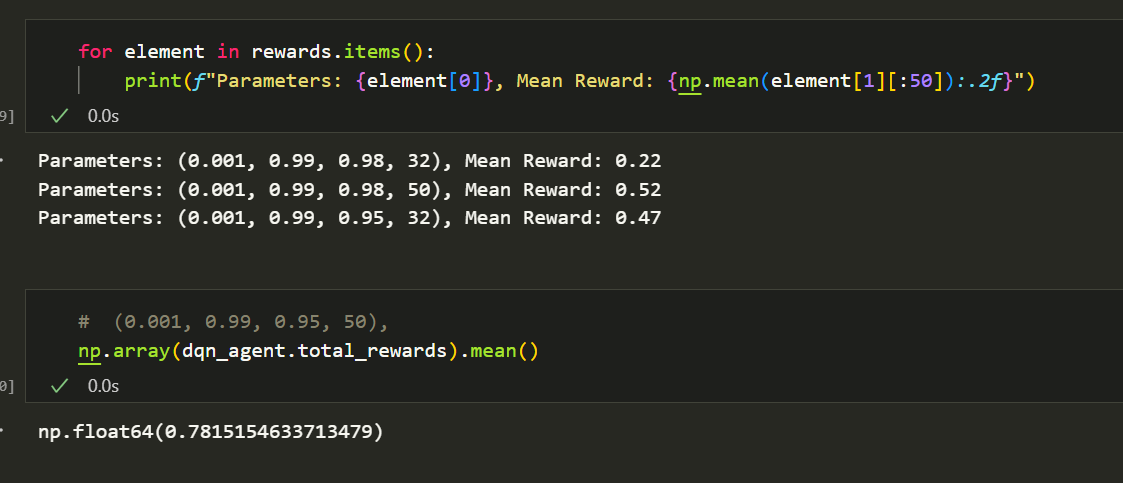

Intuitively one can figure incrementing the batch size would give better results, then the enhanced performance with a more agressive epsilon decay may be attributed to the small number of episodes, where a higher (smoother) epsilon decay doesn't give space for the explotation policy, then the model can't consolidate it's learning.

The next thing modified is the learning rate of the nn, going from 0.001 to 0.0001, this gives significantly better result (shown below), then we assume lowering the lr might improve the model's performance.

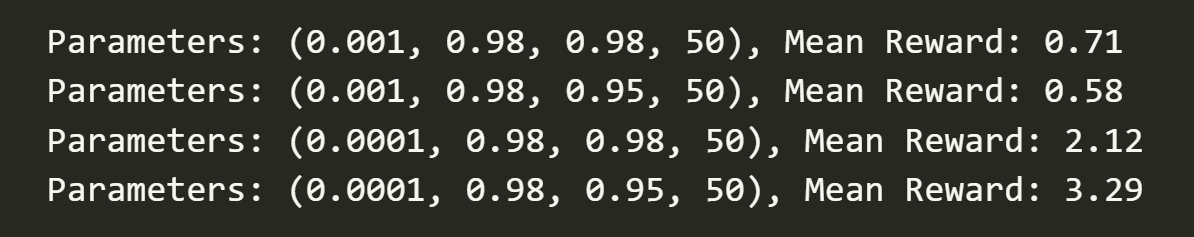

Finally gamma (the discount factor) is optimized, trying with 0.98, 0.95 and 0.90. Where the value of 0.95 provides better results.

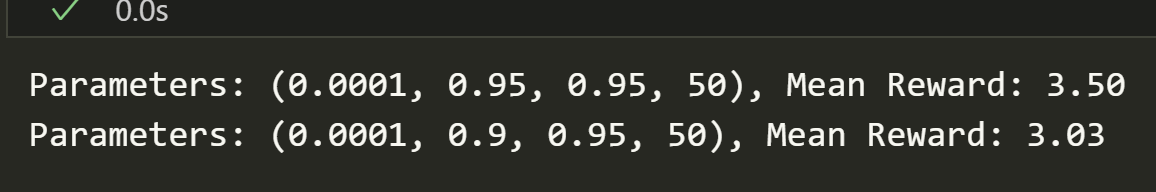

Finally we increment the window size value, to 14 and then to 21. Where the 21 observations provide a better result overall, we didn't find a significative improvement, not in the trainning rewards nor backtesting.

Then we train a model with the previous experience (lr=0.0001, gama=0.95, window size = 21, epsilon_decay=0.95, batch_size = 50) but with 350 epsiode. The rewards chart over each episode seemed to improve and consolidate a tendency after the 300 episode, then capturing very well the asset's behavior, but on the backtesting it performed fatally, meaning the model was overfitted.

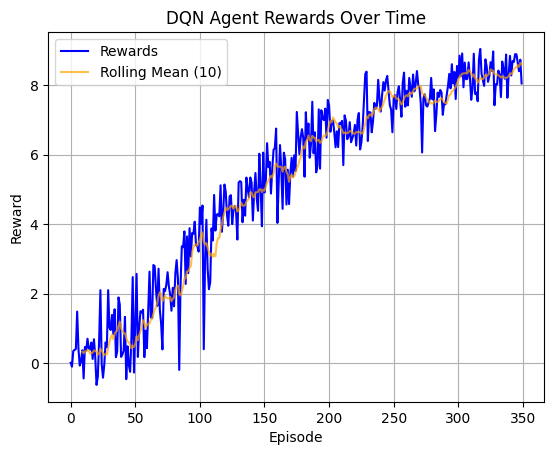

La mejor generalizacion la dió un modelo con window_size de 14, decay de 0.98, que emparejó el rendimiento del activo en buy & hold, sin embargo no lo supero.

Grafica de rewards con el reward al final del episodio

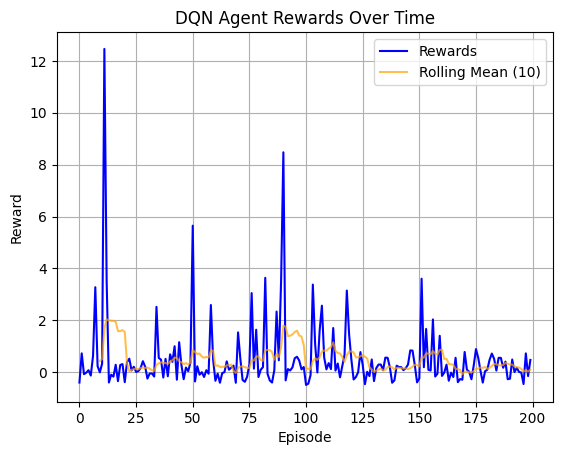

Gráfica del reward con el reward en cada paso



Reward por cada episodio cambiando el metodo de reward (retorno del portafolio en cada paso)

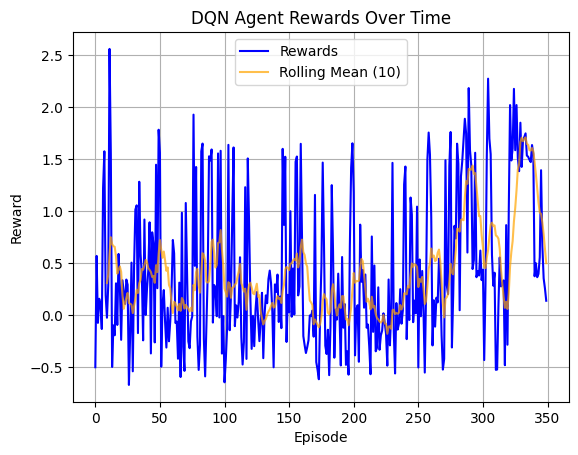

In [8]:
# n_features = 6  # Close Price, Returns, SMA_20, SMA_5, RSI, MACD
# window_size = 7 # 14 days has given the best results
# state_size = window_size * n_features + 1  # n features + position


# # Training agent with final parameters
# trading_env_training = TradingEnvironment(train, window_size,
#                                         features=['Close', 'SMA_5', 'SMA_20', 'RSI', 'MACD', 'Returns'])

# # Initialize DQN nn
# action_size = 3  # Buy, Hold, Sell
# policy_net = DQN(state_size, action_size).to(device)
# target_net = DQN(state_size, action_size).to(device)
# target_net.load_state_dict(policy_net.state_dict())
# optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)

                                
# gamma = 0.95
# epsilon = 1.0
# epsilon_min = 0.01
# epsilon_decay = 0.95

# episodes = 100  # Use 500+ if you have time/resources
# batch_size = 120
# memory = deque(maxlen=2000)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initialize DQN Agent
# dqn_agent = DQNAgent(trading_env_training, 
#                     policy_net, target_net, optimizer, memory, batch_size,
#                     device)

# # Train the DQN agent with custom parameters
# dqn_agent.train_agent(n_episodes=episodes,
#                     gamma=gamma, epsilon=epsilon, min_epsilon=epsilon_min, epsilon_decay=epsilon_decay,
#                     lr=0.001)

In [9]:
# Plotting the rewards
# data_rewards = pd.DataFrame(dqn_agent.total_rewards, columns=['Reward'])
# data_rewards['Rolling_30'] = data_rewards['Reward'].rolling(window=30).mean()
# plt.plot(data_rewards['Reward'], label='Rewards', color='blue')
# plt.plot(data_rewards['Rolling_30'], label='Rolling Mean (30)', alpha=0.7, color='orange')
# plt.title('DQN Agent Rewards Over Time')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.grid()

# 7. BACKTESTING

In [10]:
def backtest(agent, env):
    env.reset(initial_balance=100_000)
    done = False

    portfolio_values = [env.net_worth]
    actions_taken = []

    while not done:
        position = 1 if env.shares > 0 else 0
        state = env.get_state(env.current_step, position)

        # Convertimos a tensor como antes
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)

        # Obtenemos acción con la política entrenada
        with torch.no_grad():
            q_values = agent.policy_net(state_tensor)
            action = torch.argmax(q_values, dim=1).item()

        next_obs, reward, done, info = env.step_env(action)
        # print(f"Step: {env.current_step}, Action: {action}, Net Worth: {env.net_worth:.2f}")

        portfolio_values.append(env.net_worth)
        actions_taken.append(action)

    return {
        'portfolio_values': portfolio_values,
        'actions': actions_taken,
        'final_return': portfolio_values[-1] / portfolio_values[0] - 1
    }

# def get_decision(action):
#     if action == 0:
#         return "Buy"
#     elif action == 1:
#         return "Hold"
#     elif action == 2:
#         return "Sell"
#     else:
#         return "Unknown Action"

# test_env = TradingEnvironment(test, window_size,
#                               features=['Close', 'SMA_5', 'SMA_20', 'RSI', 'MACD', 'Returns'],
#                               balance=100_000)
# # Backtest the trained agent
# backtest_results = backtest(dqn_agent, test_env)

# buy_and_hold_return = (test['Close'].iloc[-1] / test['Close'].iloc[0]) - 1
# print(f"Final Return from DQN Agent: {backtest_results['final_return']*100:.2f}%")
# print(f"Buy and Hold Return: {buy_and_hold_return*100:.2f}%")

# plt.figure(figsize=(12, 6))
# plt.plot(backtest_results['portfolio_values'], label='DQN Agent Portfolio Value')
# plt.plot(test['Close'].values*(100_000/test['Close'].iloc[0]), label='BTC-USD Price', alpha=0.5)
# plt.axhline(y=test.iloc[-1]['Close']*(100_000/test['Close'].iloc[0]), color='orange', linestyle='--', label='Buy and Hold Final Value')
# plt.title('DQN Agent Portfolio Value vs BTC-USD Price')
# plt.xlabel('Time Steps')
# plt.ylabel('Portfolio Value')
# plt.legend()
# plt.grid()

# 8. RESULTADOS Y GRÁFICOS FINALES

GRAFICA DEL BACKTESTING:

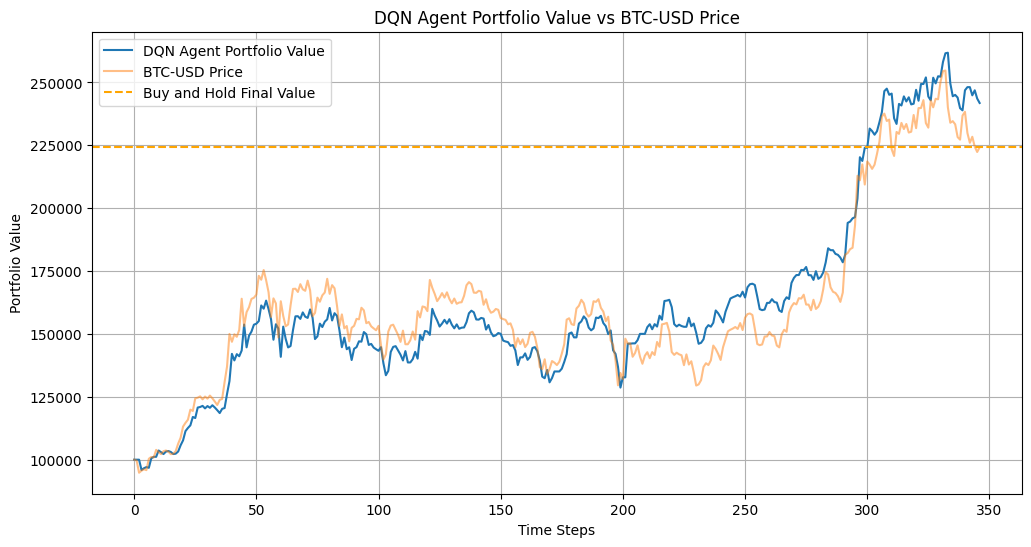


GRAFICA DE LOS REWARDS EN CADA EPISODE:

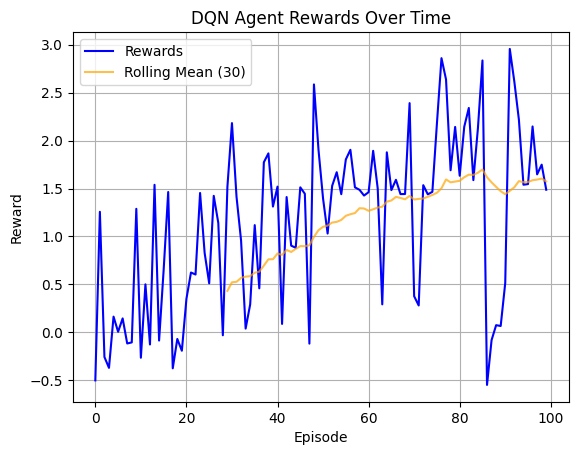

# 9. DESCARGA EL MODELO ENTRENADO

In [11]:
# Guardar el modelo entrenado de la red principal DQN
# torch.save(policy_net.state_dict(), "dql_model.pth")
# print("Modelo guardado como dql_model.pth")

### 9.1 Load and Run Model

In [13]:
# Use test data of January to July 2025 to evaluate the model with new data
data_test = yf.download('BTC-USD', start='2025-01-01', end='2025-07-01')
data_test.columns = data_test.columns.droplevel(1)

# Technical feature calculation for trading:
data_test['Returns'] = data_test['Close'].pct_change()
data_test['SMA_20'] = data_test['Close'].rolling(20).mean()
data_test['SMA_5'] = data_test['Close'].rolling(5).mean()
data_test['Trading_Signal'] = np.where(data_test['SMA_20'] > data_test['SMA_5'], 1, 0)
data_test["RSI"] = rsi_indicator(data_test['Close'])
data_test["MACD"] = macd_indicator(data_test['Close'])

# Remove rows with NaN values
data_test.dropna(inplace=True)
# Split the data into training and testing sets (80% and 20%)
split_ratio = 1
split_index = int(split_ratio * len(data_test))

data_test = data_test[:split_index]

C:\Users\tony_\AppData\Local\Temp\ipykernel_21516\782642015.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_test = yf.download('BTC-USD', start='2025-01-01', end='2025-07-01')
[*********************100%***********************]  1 of 1 completed


Final Return from DQN Agent: 13.94%
Buy and Hold Return: 5.02%


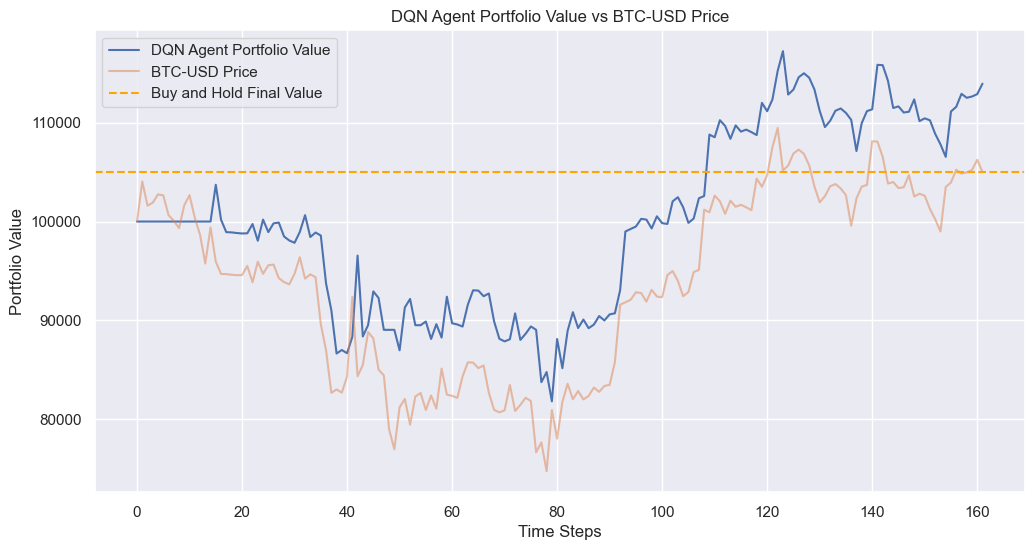

In [14]:
n_features = 6  # Close Price, Returns, SMA_20, SMA_5, RSI, MACD
window_size = 7 # 14 days has given the best results
state_size = window_size * n_features + 1  # n features + position


# Training agent with final parameters
environment_test = TradingEnvironment(data_test, window_size,
                                        features=['Close', 'SMA_5', 'SMA_20', 'RSI', 'MACD', 'Returns'],
                                        balance=100_000)

# Initialize DQN nn
action_size = 3  # Buy, Hold, Sell
# Create the nn, with same architecture as trained
policy_net = DQN(state_size, action_size).to(device)
# Load the trained weights
policy_net.load_state_dict(torch.load("dql_model_final.pth", map_location=device))
policy_net.eval()

target_net = DQN(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)

batch_size = 120
memory = deque(maxlen=2000)

# Initialize DQN Agent
dqn_agent = DQNAgent(environment_test, 
                    policy_net, target_net, optimizer, memory, batch_size,
                    device)


# Perform Backtest with the trained agent
backtest_results = backtest(dqn_agent, environment_test)

buy_and_hold_return = (data_test['Close'].iloc[-1] / data_test['Close'].iloc[0]) - 1
print(f"Final Return from DQN Agent: {backtest_results['final_return']*100:.2f}%")
print(f"Buy and Hold Return: {buy_and_hold_return*100:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(backtest_results['portfolio_values'], label='DQN Agent Portfolio Value')
plt.plot(data_test['Close'].values*(100_000/data_test['Close'].iloc[0]), label='BTC-USD Price', alpha=0.5)
plt.axhline(y=data_test.iloc[-1]['Close']*(100_000/data_test['Close'].iloc[0]), color='orange', linestyle='--', label='Buy and Hold Final Value')
plt.title('DQN Agent Portfolio Value vs BTC-USD Price')
plt.xlabel('Time Steps')
plt.ylabel('Portfolio Value')
plt.legend()

# 10. CONCLUSIÓN GENERAL


# 11. CONCLUSIONES INDIVIDUALES